# Lab 2 — Exploring Image Data
### by Eddie Diaz and Noah Barnard

## Chosen Dataset
https://www.v7labs.com/open-datasets/multiple-pose-human-body-database

## Business Understanding

This dataset was made by v7 Labs for the purpose of training machines to identify various qualities of people. The range of ML predictive capabilities using this dataset include poses, activities, gender, body type, and more. Third parties who build recognition software would benefit from these machine learning algorithms because they allow for software to identify the user, his/her features, and whichever activity they are performing. 

A machine learning algorithm that understands human behavior visually could improve the health of many people. One particular task that machines could achive in this sector is the ability for machines to gauge proper form during exercise. Although working out is crucial for long-term health, repeating incorrect movement patterns can be very detrimental. For instance, someone that performs deadlifts while bending their spine could develop chronic back problems over time. A technology-enabled tool that prevents these problems and offers corrective feedback could therefore prove highly beneficial to many people. Furthermore, by comparing a particular exercise to a trained model for both proper and improper form, it should be relatively easy for the machine to pick up on incorrect patterns with only average performance.

However, these tasks are beyond the scope of this assignment. For now, we will only endeavor to understand how machines use data reduction techniques to learn about images. For the sake of simplicity, we will trim the dataset to the first 1000 items, as this dataset contains over 25,000 pictures. Because the images seem to be in no particular order, a simple cutoff at 1000 seems like an appropriate sample.

## Data Preparation

To begin working with image data, I will first import our dependencies and load some images.

Working with 1000 images
Image examples: 
00047.jpg


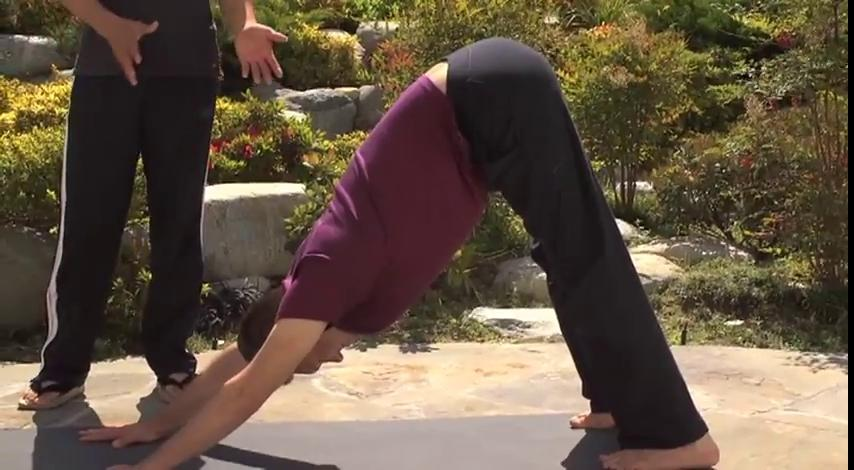

00721.jpg


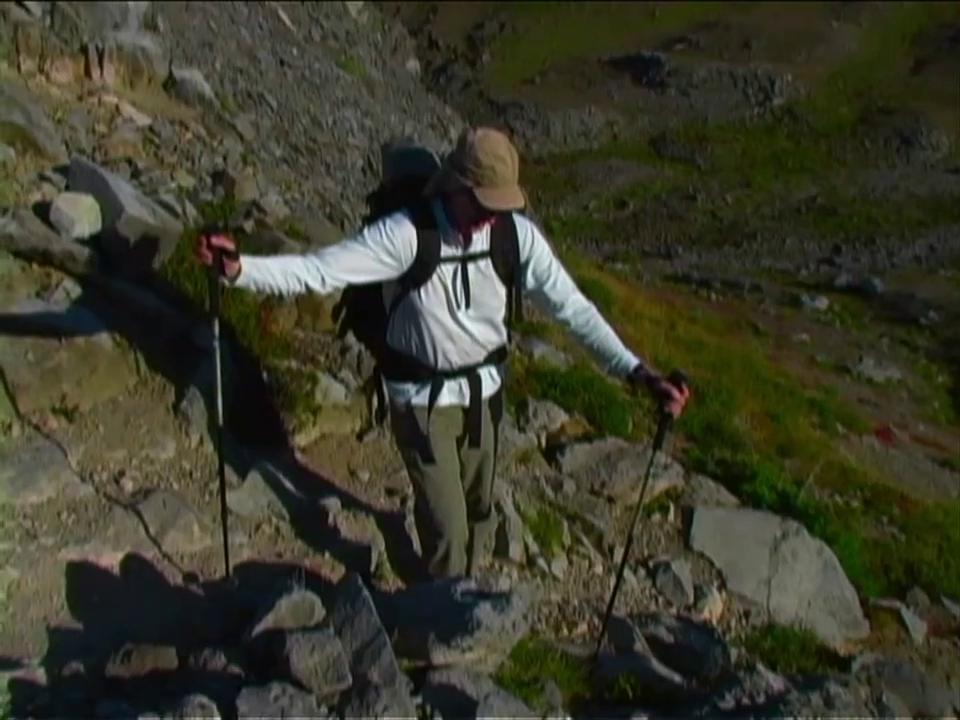

In [2]:
## import based on https://www.kaggle.com/code/lgmoneda/from-image-files-to-numpy-arrays/notebook

import numpy as np
import pandas as pd
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

folder = "./dataset"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

for i in range(40, 42):
    print(onlyfiles[i])
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=240, height=320))

Just like that, we got images! Now, these images must be converted into numpy arrays for machines to reduce and understand from numerical data. In addition, we'll convert the image data into normalized, 2D matrices for ease of manipulation. Lastly, the following code will add each image's data into a pandas dataframe, which conveniently stores each image with an assigned numerical value, the original file name, and it's entire data as a numpy array. We get the following dataframe, and to prove the images are still accessible. we'll plot the first image directly from the dataframe.

  image_name                                         image_data
1  00132.jpg  [[0.9124183006535947, 0.9124183006535947, 0.91...
2  00654.jpg  [[0.9947712418300654, 0.9947712418300654, 0.99...
3  00640.jpg  [[0.19084967320261437, 0.19477124183006533, 0....
4  00898.jpg  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5  00126.jpg  [[0.03529411764705882, 0.03529411764705882, 0....


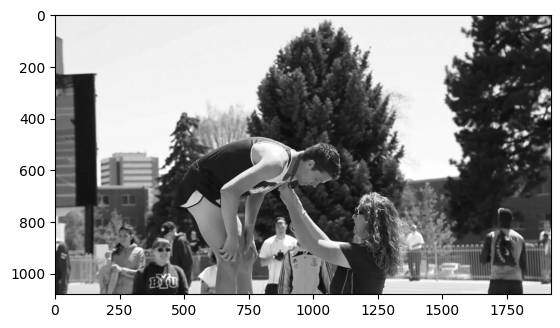

In [41]:
# The following code imports the images as numpy arrays and appends them into another array
# Custom code by Eddie, inspired by this youtube vid https://www.youtube.com/watch?v=bIOMZK5e0Oo
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

# create an empty array for 1000 image objects
images = pd.DataFrame(columns=["image_name", "image_data"])
id = 0

# import and simplify images as numpy arrays within  a larger array
for file in os.listdir(folder):
    id += 1
    img = imread(os.path.join(folder, file))
    img = img.astype(np.uint8)
    img = img/255
    img = img.mean(axis=2)
    images.loc[id] = {"image_name": file, "image_data": img}

print(images.head())
plt.imshow(images.iloc[0]["image_data"], cmap="gray")


## Data Reduction

### Reduction 1: Principal Component Analysis

The first reduction we'll perform on images is an individual PCA reconstruction on the selected image above. This exercise will enable us to understand how PCA uses feature extraction to deconstruct and better understand images. We make a function that takes two arguments: a variable percentage detail for this pca deconstruction, as well an image converted into a numpy array. The function then fits the image into the PCA model by extracting only key features. Then we recreate the same image using only the percentage of features that we call with our function. Lastly, we ask the plot to show the recreated image and we show the following results. Note how the image, pictured in full resolution above, changes with each percentage of components!

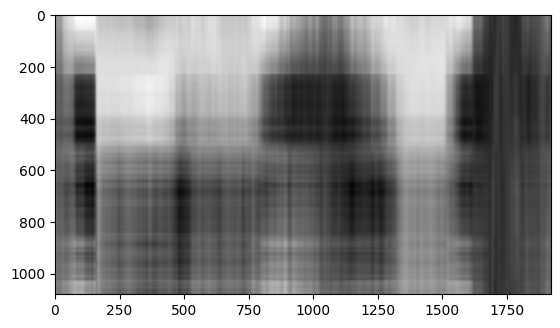

In [34]:
from sklearn.decomposition import PCA

# custom function by Eddie, inspired by same youtube video as above
# the function takes a percentage and image data as a numpy array as arguments
def pca_transform(percentage, image):
    percentage = percentage/100
    this_pca = PCA(n_components=percentage).fit(image)
    transformed = this_pca.transform(image)
    projection = this_pca.inverse_transform(transformed)
    plt.imshow(projection, cmap="gray")

pca_transform(50, images.iloc[0]["image_data"])



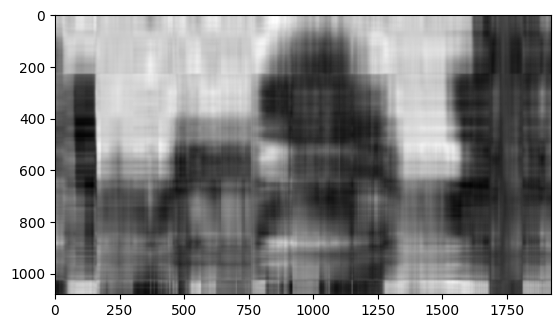

In [35]:
pca_transform(75, images.iloc[0]["image_data"])

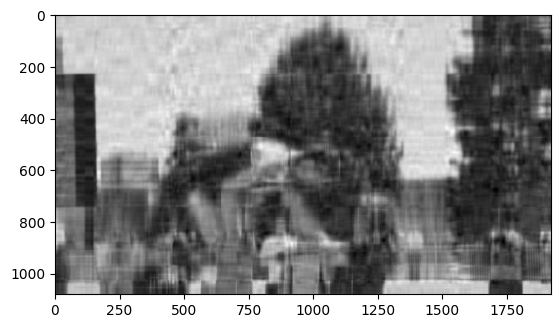

In [36]:
pca_transform(90, images.iloc[0]["image_data"])

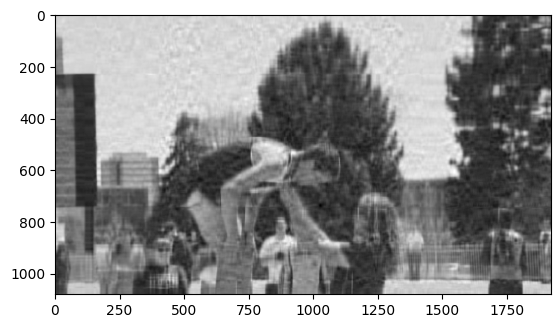

In [37]:
pca_transform(95, images.iloc[0]["image_data"])

Now we understand how PCA works. By taking a percentage of the image's total components, machines are able to extract the basic features of an image. In doing so, programs are able to understand and recreate this image based on a smaller set of data. However, as we see in the examples above, a large percentage is necessary in order to adequately recreate the image. In the examples above, any PCA recreation below 90% no longer represents the original image. Although more data efficient,these projections are too blurry to be reliable. 

The following explained variance chart corroborates this notion. As components increase closer to 100 (or beyond), the y value of the explained variance begins to approach 1 and gets closer onto infinity. This means that the more components you select for an image, the better quality recreation you'll be able to make. Nevertheless, with more data, the program also becomes less efficient at reducing the image because you're still keeping a lot of it.

In [38]:
# explained variance based on code from Dr. Larson's notebook

# set X to image data
X = images.iloc[0]["image_data"]

# create a PCA object
pca = PCA(n_components=150)
X_pca = pca.fit(X)

# create explained variance plot as function
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

#call function
plot_explained_variance(pca)

### Reduction 2: Randomized PCA



## Reduction 3: DAISY Feature Extraction

Daisy is an algorithmic extraction process that reduces images based on a number of set parameters. These parameters draw circular graphs over the image which will then be saved as a reduced subset of the original image. Because this technique is more advanced than PCA, it is very promising to our predictive task.

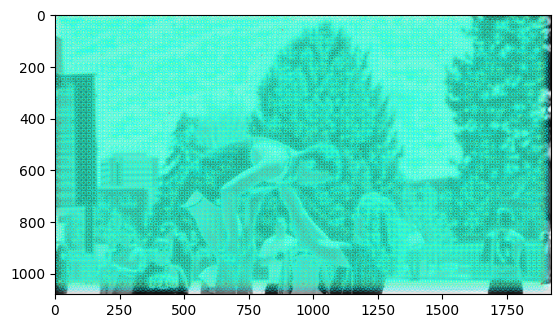

In [43]:
from skimage.feature import daisy

# from Dr. Larson's notebook
features, img_desc = daisy(images.iloc[0]["image_data"], 
                           step=20, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
plt.imshow(img_desc)
plt.grid(False)

Although we can see how Daisy makes edges more visible within it's reduction, this image is not very telling of how daisy actually works. Let's try again with different parameters. Namely, we'll increase the steps between circles and their radius to better fit the image's resolution

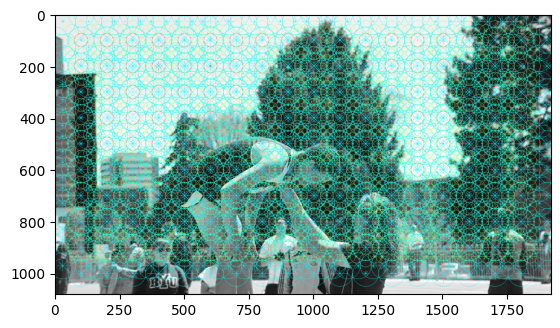

In [45]:
features, img_desc = daisy(images.iloc[0]["image_data"], 
                           step=100, 
                           radius=100, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
plt.imshow(img_desc)
plt.grid(False)

Now we can se the DAISY algroithm at work. Essentially, the areas underneath the circles can be saved as an outline of the original image. Because these circles are formatted to contain the majority of the image's important features, it can be an effective way to reduce an image into it's primary components while discarding most of the image. 

Although these tools can be powerful aids in for machine learning, they may not help our predictive task with the provided dataset. As we saw in the picture above, these images are too large for DAISY to work appropriately. The algorithm would create too many circles and save too much data, to the point where running the algorithm itself becomes more of an expense than an aid. These observations are further corroborated by the fact that images in the v7 database have different resolutions, which could also make DAISY a difficult feature extraction method because we'd have to set individual parameters for each image. Lastly, Dr Larson's feature reduction will not work on these images because they are too large. Note the error below.

In [61]:
# based on Dr. Larson's code. 
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=100, radius=100, 
                 rings=2, histograms=8, orientations=8, 
                 visualize=False)
    return feat.reshape((-1))

test_feature = apply_daisy(X[3],(X.shape))
test_feature.shape

ValueError: cannot reshape array of size 1920 into shape (1080,1920)

## Reduction 4: Gabor Filter

Gabor filters are essentially convolution operations between an image and a generic pattern. By convoluting the image with a desired filter, one can extract more exact features desired from a given image. The following code makes gabor filters from scratch, and them applies them to the image above.

1.5140274644582022e-05

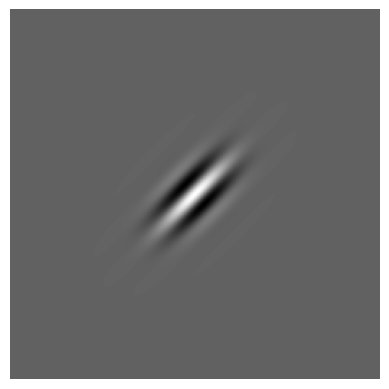

In [57]:
## based on this Jupyter notebook http://vision.psych.umn.edu/users/kersten/kersten-lab/courses/Psy5036W2017/Lectures/17_PythonForVision/Demos/html/2b.Gabor.html
## making our first gabor filter

def myimshow(I, **kwargs):
    # utility function to show image
    plt.figure();
    plt.axis('off')
    plt.imshow(I, cmap=plt.gray(), **kwargs)


def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
#     myimshow(gauss)
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
#     myimshow(sinusoid)
    gabor = gauss * sinusoid
    return gabor
        
g = genGabor((256,256), 0.3, np.pi/4, func=np.cos) 
# change func to "cos", "sin" can generate sin gabor or cos gabor, here we pass a function name as a parameter
myimshow(g)
np.mean(g)

Ok, now that we can make a single gabor filter, let's make a lot of them to best convolute our image without any directional bias. 

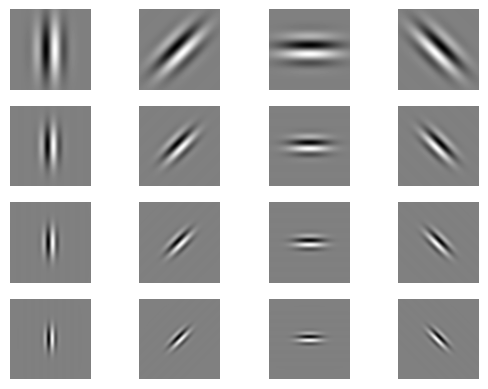

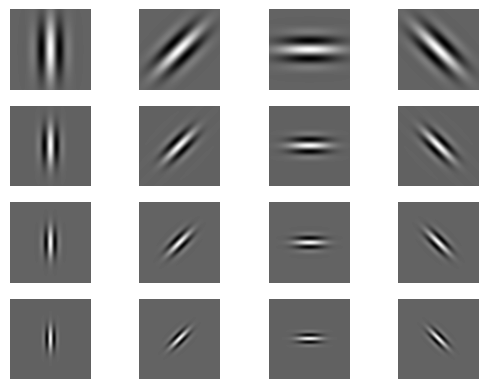

In [59]:
## based on the same notebook, now to make a bank for filters

theta = np.arange(0, np.pi, np.pi/4) # range of theta
omega = np.arange(0.2, 0.6, 0.1) # range of omega
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(128, 128)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)

plt.figure()
n = len(sinFilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(sinFilterBank[i])

plt.figure()
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(cosFilterBank[i])

Now we have a collection of various filters to effectively convolute our images. Let's try them on the medal recipient image that we worked on above.

<Figure size 640x480 with 0 Axes>

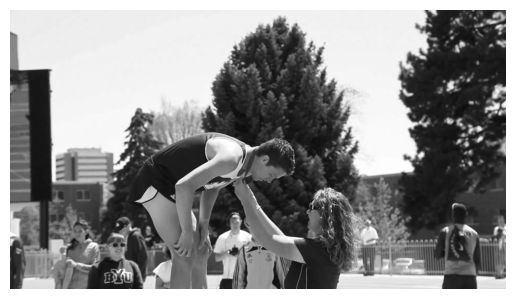

<Figure size 640x480 with 0 Axes>

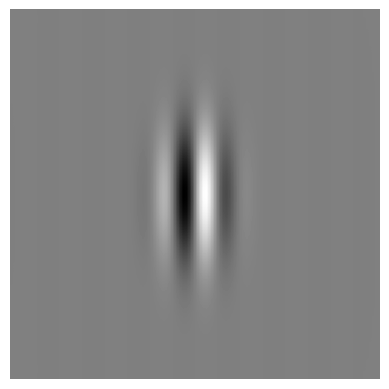

<Figure size 640x480 with 0 Axes>

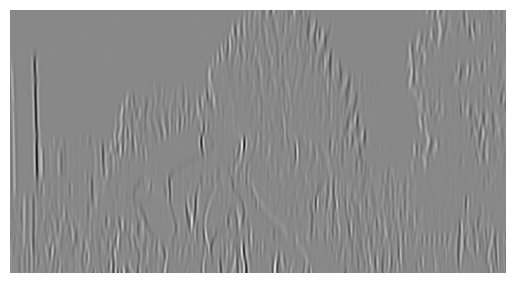

In [60]:
from scipy.signal import convolve2d
champ = images.iloc[0]["image_data"]
plt.figure(); myimshow(champ)
sinGabor = sinFilterBank[8] 
plt.figure(); myimshow(sinGabor)
res = convolve2d(champ, sinGabor, mode='valid') # Will take about one minute
plt.figure(); myimshow(res);

As we can see, the filtered image retains much of the original image's details, but most of the important features (the people) are now hardly discernible. Based on this application, I believe that a gabor image is best suited for images where the main components are featured without much noise, as the filtered image above shows more tree outlines than people. Furthermore, these filters may also become more effective when the person that creates the features tailors them to the exact patterns that we are trying to extract. However, the v7 database contains a lot of variety between people, activities, resolutions, and more. These images are truly unique, and it is difficult to standardize them to a specific generic filter for convolution. Therefore, we must suggest that unless the machine learning engineer really knows what they are doing, they should stick to simpler techniques instead for best results.